In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [224]:
SAMPLE_RATE_HZ = 1000
TIME_MS = 500

SIGNAL_FREQ_HZ = 3
NOISE_FREQ_HZ = 50

samples = np.arange(TIME_MS / 1000 * SAMPLE_RATE_HZ) / SAMPLE_RATE_HZ

signal = np.sin(2 * np.pi * samples * SIGNAL_FREQ_HZ) 
noise = np.sin(2 * np.pi * samples * NOISE_FREQ_HZ) * 0.5 # noise amplitude

In [225]:
df_source = pd.DataFrame(list(zip(signal, noise, signal+noise)), columns=['signal', 'noise', 'signal+noise'])

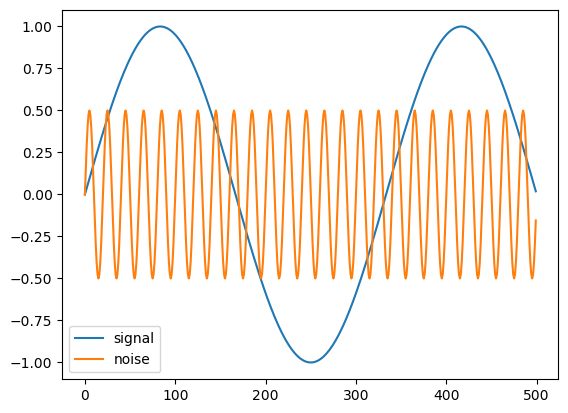

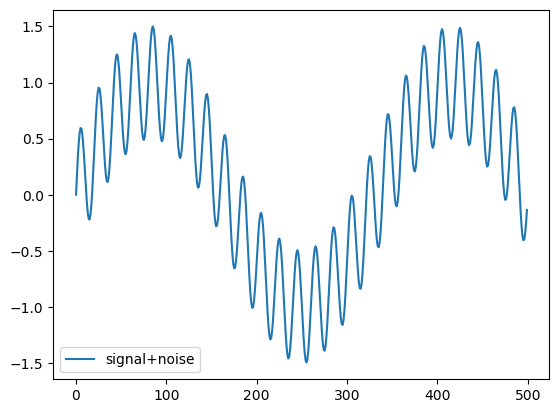

In [226]:
df_source.plot(y=['signal', 'noise'])
df_source.plot(y=['signal+noise'])
plt.show()

## Second order allpass filter

In [56]:
def second_order_allpass_filter(break_frequency, bandwidth, fs):
    tan = np.tan(np.pi * bandwidth / fs)
    c = (tan - 1) / (tan + 1)
    d = - np.cos(2 * np.pi * break_frequency / fs)
    
    b = [-c, d * (1 - c), 1]
    a = [1, d * (1 - c), -c]
    
    return b, a

def bandstop_bandpass_filter(input_signal, Q, center_frequency, fs, bandpass=False):
    # Calculate the bandwidth from Q and center frequency
    bandwidth = center_frequency / Q

    # Get the allpass coefficients
    b, a = second_order_allpass_filter(center_frequency, bandwidth, fs)

    # For storing the allpass output
    allpass_filtered = np.zeros_like(input_signal)
    
    # Initialize filter's buffers
    x1 = x2 = y1 = y2 = 0
    
    # Process the input signal with the allpass
    for i in range(input_signal.shape[0]):        
        x = input_signal[i]
        
        # Actual allpass filtering:
        # difference equation of the second-order allpass
        y = b[0] * x + b[1] * x1 +  b[2] * x2 - a[1] * y1 - a[2] * y2
        
        # Update the filter's buffers
        y2 = y1
        y1 = y
        x2 = x1
        x1 = x
        
        # Assign the resulting sample to the output array
        allpass_filtered[i] = y
    
    # Should we bandstop- or bandpass-filter?
    sign = -1 if bandpass else 1
    
    # Final summation and scaling (to avoid clipping)
    output = 0.5 * (input_signal + sign * allpass_filtered)

    return output

In [236]:
bsf = bandstop_bandpass_filter(df['signal+noise'], Q=1.0, center_frequency=50.0, fs=SAMPLE_RATE_HZ)
bpf = bandstop_bandpass_filter(df['signal+noise'], Q=10.0, center_frequency=50.0, fs=SAMPLE_RATE_HZ, bandpass=True)

In [237]:
df_result = pd.DataFrame(list(zip(signal+noise, bsf, bpf)), columns=['signal+noise', 'band stop filter', 'band pass filter'])

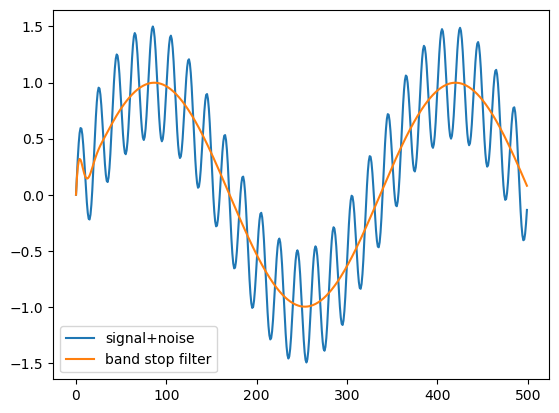

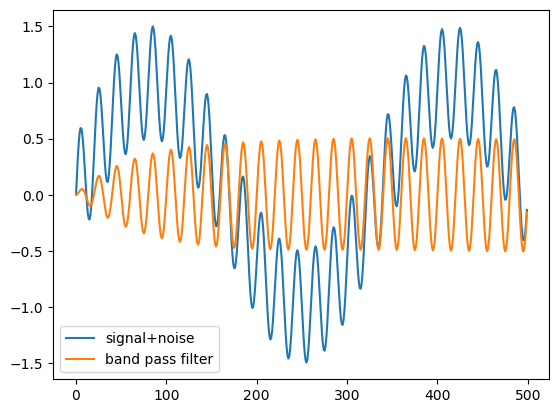

In [238]:
df_result.plot(y=['signal+noise', 'band stop filter'])
df_result.plot(y=['signal+noise', 'band pass filter'])
plt.show()